## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from scipy import stats
import os
from os.path import join, basename
from collections import deque
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio 
import time
import pandas as pd
%matplotlib inline

In [401]:
from numpy.linalg import det, norm

In [2]:
import plotly
import plotly.figure_factory as ff
plotly.offline.init_notebook_mode(connected=True)

In [36]:
imageio.plugins.ffmpeg.download()

## Test on images

In [349]:
class laneLineDetector:
    def __init__(self):
        """
        parameter for pipeline
        """
        self.houghLine_para = { "rho": 1, "theta": np.pi/180, "threshold": 15, "min_line_len": 40, "max_line_gap": 5, "filter_y_uppderbound": 0 }
        self.canny_para = { "low_threshold": 0, "high_threshold": 200}
        self.gaussian_blur_para = { "kernel_size": 5}
        self.auxiliary_points = np.array([[(0, 0),(0, 0), (0, 0)]], dtype=np.int32)
        
        # image
        self.gray_image = None
        self.canny_img = None
        self.blurred_img = None
        self.masked_image = None
        
        """
        data cache for hough_lines
        """
        self.houghLines = None
        self.right_lines = None 
        self.left_lines = None 
        self.left_center = None 
        self.right_center = None 
        
        """
        data cache from hough_line_filter result
        """
        self.left_slope_upperbound = -0.5
        self.left_slope_lowerbound = -1.0

        self.right_slope_upperbound = 1.0
        self.right_slope_lowerbound = 0.5

        self.left_intercept_upperbound =  900.0
        self.left_intercept_lowerbound = 560.0  # 540 + 20

        self.right_intercept_upperbound = 100.0
        self.right_intercept_lowerbound = 20.0 # 0 + 20

        self.left_length_upperbound = 1000.0
        self.left_length_lowerbound = 0.0 

        self.right_length_upperbound = 1000.0 
        self.right_length_lowerbound = 0.0
        
        self.slope = None 
        self.intercept = None 
        self.length = None
        
    def process_image(self, img):
        imshape = img.shape
        self.auxiliary_points = np.array([[(0,imshape[0]),(imshape[1]//2, imshape[0]//2), (imshape[1],imshape[0])]], dtype=np.int32)
        self.houghLine_para["filter_y_uppderbound"] = imshape[0]

        self.gray_image = self.grayscale(img) # output an image with only one color channel
        self.canny_img = self.canny(self.gray_image, self.canny_para["low_threshold"], self.canny_para["high_threshold"])

        self.blurred_img = self.gaussian_blur(self.canny_img, self.gaussian_blur_para["kernel_size"])
        self.masked_image = self.region_of_interest(self.blurred_img, self.auxiliary_points)
        for i in self.auxiliary_points[0]:
            self.draw_circle(self.masked_image, tuple(i), 20, (255,0,0), thickness = 5)

        line_img = self.hough_lines(self.masked_image
                                   , self.houghLine_para["rho"]
                                   , self.houghLine_para["theta"]
                                   , self.houghLine_para["threshold"]
                                   , self.houghLine_para["min_line_len"]
                                   , self.houghLine_para["max_line_gap"]
                                   , self.houghLine_para["filter_y_uppderbound"]) 
        
        self.draw_triangle(img, self.auxiliary_points, (0,255,0), 10)

        return self.weighted_img(img, line_img)
    
    def hough_lines(self, img, rho, theta, threshold, min_line_len, max_line_gap, filter_y_uppderbound):
        
        self.houghLines = np.squeeze(cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap), axis=1)

        """
        separate lines into left lines and right lines based on slope
        """
        self.right_lines, self.left_lines, self.left_center, self.right_center = self.hough_line_filter(self.houghLines.T, filter_y_uppderbound//2)
        

        """
        extrapolation 
        """
#         Lane_Y_lowerbound = min(self.left_center[1], self.right_center[1])
#         Lane_Y_upperbound = filter_y_uppderbound

#         left_x = np.concatenate((self.left_lines[0], self.left_lines[2]), axis=0)
#         left_y = np.concatenate((self.left_lines[1], self.left_lines[3]), axis=0)

#         right_x = np.concatenate((self.right_lines[0], self.right_lines[2]), axis=0)
#         right_y = np.concatenate((self.right_lines[1], self.right_lines[3]), axis=0)

#         left_slope, left_intercept = self.get_fitLineCharacter(left_x, left_y)
#         right_slope, right_intercept = self.get_fitLineCharacter(right_x, right_y)

#         left_Lane_X_upperbound, left_Lane_X_lowerbound, right_Lane_X_upperbound, right_Lane_X_lowerbound = self.get_fitLane(left_slope, left_intercept, right_slope, right_intercept
#                                                                                                                         , Lane_Y_lowerbound, Lane_Y_upperbound)
#         if left_Lane_X_upperbound > right_Lane_X_lowerbound:
#             left_Lane_X_upperbound = (right_intercept - left_intercept)/(left_slope - right_slope)
#             right_Lane_X_lowerbound = left_Lane_X_upperbound
#             Lane_Y_lowerbound = left_Lane_X_upperbound * left_slope + left_intercept

        line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #     draw_lines(line_img, [[left_Lane_X_upperbound, Lane_Y_lowerbound, left_Lane_X_lowerbound, Lane_Y_upperbound]
    #                           ,[right_Lane_X_upperbound, Lane_Y_upperbound, right_Lane_X_lowerbound, Lane_Y_lowerbound]])
        self.draw_lines(line_img, self.right_lines.T, color=[255, 255, 0], thickness=10)
        self.draw_lines(line_img, self.left_lines.T, color=[255, 0, 255], thickness=10)

        return line_img

    def hough_line_filter(self, lines, filter_y_uppderbound):
        
        lines = lines[:,lines[1] > filter_y_uppderbound]
                
        # calculate the slope, intercept and length of the lines for visualization
        self.slope = np.divide(lines[1]-lines[3], lines[0]-lines[2])
        self.intercept = lines[1] - (self.slope * lines[0])
        self.length = np.sqrt(np.sum(np.square([lines[1]-lines[3],lines[0]-lines[2]]), axis = 0))

        """
        filter
        1: slope
        2: intercept
        3: length
        """
        # right lines filters: 
        right_condition = (self.slope >= self.right_slope_lowerbound) & (self.slope < self.right_slope_upperbound)\
                           & (self.intercept >= self.right_intercept_lowerbound) & (self.intercept < self.right_intercept_upperbound)\
                           & (self.length >= self.right_length_lowerbound) & (self.length < self.right_length_upperbound)
        self.right_lines = (lines[:,np.array(right_condition)])

        # left lines filter: 
        left_condition = (self.slope >= self.left_slope_lowerbound) & (self.slope < self.left_slope_upperbound)\
                           & (self.intercept >= self.left_intercept_lowerbound) & (self.intercept < self.left_intercept_upperbound)\
                           & (self.length >= self.left_length_lowerbound) & (self.length < self.left_length_upperbound)
        self.left_lines = (lines[:,np.array(left_condition)])
        
        right_ref_x, right_ref_y = 0, 0
        
        if self.right_lines.shape[1] == 0:
            print ("right 0")
            right_ref_x, right_ref_y, _, _ = lines[:,np.argmax(self.slope)]
            self.right_lines = lines[:,np.argmax(self.slope)].reshape(4,1)    
        else:
            right_ref_x, right_ref_y, _, _ = self.right_lines[:,0]        

        left_ref_x, left_ref_y = 0, 0

        if self.left_lines.shape[1] == 0:
            print ("left 0")
            _, _, left_ref_x, left_ref_y = lines[:,np.argmin(self.slope)]
            self.left_lines = lines[:,np.argmin(self.slope)].reshape(4,1)    
        else:
            left_max_x_arg = np.argmax(self.left_lines[2], axis=0)
            _, _, left_ref_x, left_ref_y = self.left_lines[:,left_max_x_arg]

        """
        visualize before filter
        """
        self.viz_line_features()    
        
        return self.right_lines, self.left_lines, (left_ref_x, left_ref_y), (right_ref_x, right_ref_y)    

    
    def Output_img(self, out_path, img):
        return cv2.imwrite(out_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))      

    def grayscale(self, img):
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    def canny(self, img, low_threshold, high_threshold):
        return cv2.Canny(img, low_threshold, high_threshold)

    def gaussian_blur(self, img, kernel_size):
        return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

    def region_of_interest(self, img, vertices):
        mask = np.zeros_like(img)   
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255

        cv2.fillPoly(mask, vertices, ignore_mask_color)

        masked_image = cv2.bitwise_and(img, mask)
        return masked_image

    def weighted_img(self, initial_img, img, α=1.0, β=0.8, λ=0.):
        """
        initial_img * α + img * β + λ
        """
        return cv2.addWeighted(initial_img, α, img, β, λ)

    def get_fitLane(self, left_slope, left_intercept, right_slope, right_intercept, Y_lowerbound, Y_upperbound):
        """
        return left and right fitting lane lines
        """
        return ((Y_lowerbound - left_intercept)/left_slope
                , (Y_upperbound - left_intercept)/left_slope
                , (Y_upperbound - right_intercept)/right_slope
                , (Y_lowerbound - right_intercept)/right_slope)

    def get_fitLineCharacter(self, x, y):
        """
        format is y = slope * x + intercept
        """
        slope, intercept, _, _, std_err = stats.linregress(x,y)
        return slope, intercept

    def draw_lines(self, img, lines, color=[255, 0, 0], thickness=10):
        for x1, y1, x2, y2 in lines:
            cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)

    def draw_circle(self, img, center, radius, color, thickness = 5):
        cv2.circle(img, center, radius, color, thickness)

    def draw_triangle(self, img, vertex, color, thickness = 5):
        cv2.polylines(img, [vertex], True, color,thickness)
        
    def viz_line_features(self):
        line_num = self.slope.shape[0]
        
        self.slope = np.reshape(self.slope, (1, line_num))
        self.intercept = np.reshape(self.intercept, (1, line_num))
        self.length = np.reshape(self.length, (1, line_num))
            
        input_scatterPlot = np.concatenate((self.slope.T, self.intercept.T, self.length.T), axis=1)        
        dataframe = pd.DataFrame(input_scatterPlot, columns=['Slope', 'Intercept', 'Length'])

        dataframe['lineSign'] = pd.Series(np.squeeze(np.where(img_obj.slope >=.0, 'right', 'left'), axis=0))
        fig = ff.create_scatterplotmatrix(dataframe, diag='histogram', index='lineSign', height=800, width=800)
        plotly.offline.iplot(fig, filename='Box plots along Diagonal Subplots')

    def Distance point_to_line_distance(self, A, B, P):
def distance(A, B, P):
    """ segment line AB, point P, where each one is an array([x, y]) """
    if all(A == P) or all(B == P):
        return 0
    if arccos(dot((P - A) / norm(P - A), (B - A) / norm(B - A))) > np.pi / 2:
        return norm(P - A)
    if arccos(dot((P - B) / norm(P - B), (A - B) / norm(A - B))) > np.pi / 2:
        return norm(P - B)
    return abs(dot(A - B, P[::-1]) + det([A, B])) / norm(A - B)

In [411]:
def distance(A, B, P):
    """ segment line AB, point P, where each one is an array([x, y]) """
    if arccos(dot((P - A) / norm(P - A), (B - A) / norm(B - A))) > np.pi / 2:
        print (1)
        return norm(P - A)
    if arccos(dot((P - B) / norm(P - B), (A - B) / norm(A - B))) > np.pi / 2:
        print (2)
        return norm(P - B)
    print (3)
    return abs(dot(A - B, P[::-1]) + det([A, B])) / norm(A - B)

In [412]:
P = np.array([-2, -4])
A = np.array([3, 1])
B = np.array([9,-1])
# print (P-A)
# print (P-B)
# print (A-B)
# print(np.linalg.norm(P - A))
# np.dot(P - A, P -B)
distance(A, B, P)

1


7.0710678118654755

In [ ]:
arccos

In [350]:
# test on images
test_images_dir = 'test_images'
test_images = [join(test_images_dir, name) for name in os.listdir(test_images_dir)]
img_obj = laneLineDetector()

# for test_img in test_images:

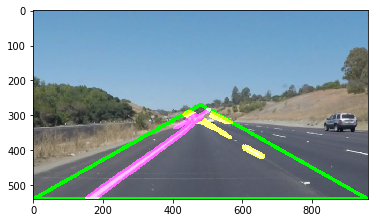

In [384]:
# plt.imshow(img_obj.gray_image)
# plt.imshow(img_obj.canny_img)
# plt.imshow(img_obj.blurred_img) 
# plt.imshow(img_obj.masked_image)
plt.imshow(out_image)

In [385]:
print (img_obj.left_lines.shape[1])
print (img_obj.right_lines.shape[1])

38
22


In [386]:
img_obj.intercept[(img_obj.intercept > -200.0) & (img_obj.intercept < 90.0)]

array([ 42.28571429,  22.63888889,  25.        ,  42.88      ,
        36.85106383,  56.        ,  22.90291262,  87.55319149,
        70.        ,  22.79591837,  88.93023256,  60.73469388,
         9.6744186 ,  61.61538462,  61.76923077,  31.83636364,
        71.63157895,  23.72727273,  61.09090909,  28.875     ,
        49.025     ,  32.80434783])

In [380]:
img_obj.left_slope_upperbound = -0.5
img_obj.left_slope_lowerbound = -1.0

img_obj.right_slope_upperbound = 3.0
img_obj.right_slope_lowerbound = 0.3

img_obj.left_intercept_upperbound =  900.0
img_obj.left_intercept_lowerbound = 560.0  # 540 + 20

img_obj.right_intercept_upperbound = 90.0
img_obj.right_intercept_lowerbound = -40.0 # 0 + 20

img_obj.left_length_upperbound = 1000.0
img_obj.left_length_lowerbound = 0.0 

img_obj.right_length_upperbound = 1000.0 
img_obj.right_length_lowerbound = 0.0

In [383]:
test_img = test_images[2]

print('Processing image: {}'.format(test_img))
out_path = join('test_images_output', basename(test_img))

in_image = cv2.cvtColor(cv2.imread(test_img, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
out_image = img_obj.process_image(in_image)
img_obj.Output_img(out_path, out_image)


Processing image: test_images\solidYellowCurve.jpg


True

Processing image: test_images\solidWhiteCurve.jpg


True

## Output error image

In [206]:
# test on videos challenge
test_videos_dir = 'test_videos'
test_videos = [join(test_videos_dir, name) for name in os.listdir(test_videos_dir)]
test_videos = [test_videos[0]]
test_videos

['test_videos\\challenge.mp4']

In [390]:
resize_h, resize_w = 540, 960
for test_video in test_videos:
    print('Processing video: {}'.format(test_video))
    cap = cv2.VideoCapture(test_video)
    in_image = None
    a = 0
    img_obj = laneLineDetector()
    try:
        while cap.isOpened():

            # cap.read() returns a bool (True/False). If frame is read correctly, it will be True. End of the video can be checked with this return value.
            ret, color_frame = cap.read()
            if ret:
                a+=1; print ("the: {} image".format(a))
                                
                in_image = cv2.cvtColor(color_frame, cv2.COLOR_BGR2RGB)
                in_image_cp = np.copy(in_image)
                
                out_image = process_image(in_image_cp)
                
                correct_out_path = join('test_images_from_video', 'solidYellowLeft_' + str(a) + ".jpg")
                Output_error_img(correct_out_path, cv2.cvtColor(out_image, cv2.COLOR_RGB2BGR)) 
                
            else:
                break
        print ("transform ends")
        
    except ValueError as e:    
        error_out_path = join('test_images_from_video_error_output', 'solidYellowLeft_' + str(a) + ".jpg")
        Output_img(error_out_path, in_image) 
        print ("ValueError:" + str(e))

    except IndexError as e:
        error_out_path = join('test_images_from_video_error_output', 'solidYellowLeft_' + str(a) + ".jpg")
        Output_img(error_out_path, in_image) 
        print ("IndexError:" + str(e))
    finally:
        cap.release()
        out.release()
        cv2.destroyAllWindows()

Processing video: test_videos\challenge.mp4
the: 1 image
the: 2 image
the: 3 image
the: 4 image
the: 5 image
the: 6 image
the: 7 image
the: 8 image
the: 9 image
the: 10 image
the: 11 image
the: 12 image
the: 13 image
the: 14 image
the: 15 image
the: 16 image
the: 17 image
the: 18 image
the: 19 image
the: 20 image
the: 21 image
the: 22 image
the: 23 image
the: 24 image
the: 25 image
the: 26 image
the: 27 image
the: 28 image
the: 29 image
the: 30 image
the: 31 image
the: 32 image
the: 33 image
the: 34 image
the: 35 image
the: 36 image
the: 37 image
the: 38 image
the: 39 image
the: 40 image
the: 41 image
the: 42 image
the: 43 image
the: 44 image
the: 45 image
the: 46 image
the: 47 image
the: 48 image
the: 49 image
the: 50 image
the: 51 image
the: 52 image
the: 53 image
the: 54 image
the: 55 image
the: 56 image
the: 57 image
the: 58 image
the: 59 image
the: 60 image
the: 61 image
the: 62 image
the: 63 image
the: 64 image
the: 65 image
the: 66 image
the: 67 image
the: 68 image
the: 69 image

In [379]:
in_image = cv2.cvtColor(cv2.imread("test_images\\solidWhiteCurve.jpg", cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

In [7]:
videoSaved_dir = "test_videos_output"
if not os.path.exists(videoSaved_dir):
    os.makedirs(videoSaved_dir)


white_output = videoSaved_dir + '/solidWhiteRight.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
# white_output.subclip(0,2)

## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("test_videos//solidWhiteRight.mp4").subclip(0,5)
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")

In [9]:
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
# %time white_clip.write_videofile(white_output, fps=10, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [77]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:21<00:00, 30.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 22.4 s


In [78]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))